In [1]:
from qiskit import QuantumCircuit, transpile
from math import pi

In [2]:
NUM_QUBITS = 3
NUM_LAYERS = 1
SHOTS = 1000

In [3]:
def add_permutions(qc: QuantumCircuit):
    for i in range(qc.num_qubits):
        angle = pi * (i / (qc.num_qubits - 1))
        qc.u(angle, angle, angle, i)

def add_entanglements(qc: QuantumCircuit, cx: bool=False, u: bool=True):
    for i in range(qc.num_qubits):
        if cx:
            qc.cx(i, (i + 1) % qc.num_qubits)
        if u:
            angle = pi * ((qc.num_qubits - 1 - i) / (qc.num_qubits - 1))
            qc.cu(angle, angle, angle, 0, i, (i + 1) % qc.num_qubits)

def add_inverse(qc: QuantumCircuit):
    qc &= qc.inverse()

def generate_permuted_mirror_circuit(num_qubits: int, num_layers: int) -> QuantumCircuit:
    qc = QuantumCircuit(num_qubits)
    for _ in range(num_layers):
        add_permutions(qc)
        add_entanglements(qc)
        add_inverse(qc)
    return qc

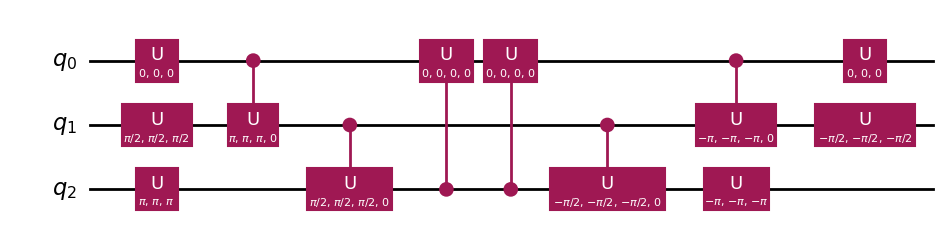

In [4]:
qc = generate_permuted_mirror_circuit(num_qubits=NUM_QUBITS, num_layers=NUM_LAYERS)
qc.draw('mpl')

Result (optimal=3): 3 * 954 / 1000 = 2.862


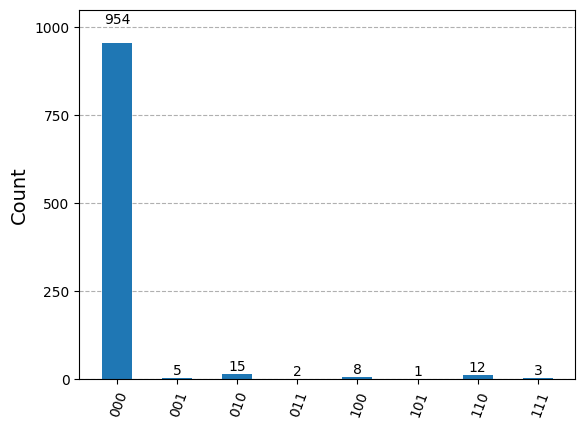

In [5]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.visualization import plot_histogram

backend = GenericBackendV2(qc.num_qubits)
t_qc = transpile(circuits=qc, backend=backend, optimization_level=0)  # prevent benchmark being optimized away
t_qc.measure_all()

counts = backend.run(run_input=t_qc, shots=SHOTS).result().get_counts()
result = qc.num_qubits * counts.get("0" * len(set(counts.keys()).pop()), 0) / SHOTS

print(
    f"Result (optimal={qc.num_qubits}): {qc.num_qubits} * {counts.get("0" * len(set(counts.keys()).pop()), 0)} / {SHOTS} = {result}"
)

plot_histogram(counts)